# Gaussian processes with outliers

Suppose there are data distributed according a noisy Gaussian process with outliers at places.
Doing inference with outliers renders the inference useless, and is indeed where point-wise marginal likelihood maximisation falls flat on its face.
With JAXNS we can marginalise over hyper parameters as easily as defining them as prior RVs and marginalising over the posterior.

A Gaussian process is defined by a covariance function, $K : \mathcal{X} \times \mathcal{X} \to \mathbb{R}$, and a mean function $\mu : \mathcal{X} \to \mathbb{R}$.
Given the above data we see that it is equivalent to a Gaussian likelihood, with Gaussian process prior,

$L(x) = p(y | x) = \mathcal{N}[y \mid x, \Sigma]$

and

$p(x) = \mathcal{N}[x \mid \mu(X), K(X,X)]$

where $\mu(X)$ and $K(X,X)$ are the mean and covariance functions evaluated over the coordinate locations of the data.

The evidence of this model is well known,

$Z \triangleq p(y) = \int_\mathcal{X} L(x) p(x) \,\mathrm{d} x = \mathcal{N}[y \mid \mu(X), K(X,X) + \Sigma)$

and likewise the posterior distribution is,

$p(x \mid y) = \mathcal{N}[x \mid \mu', K']$

where

$\mu' = \mu(X) + K(X,X) (K(X,X) + \Sigma)^{-1}(y - \mu(X))$

and

$K' = K(X,X) - K(X,X) (K(X,X) + \Sigma)^{-1} K(X,X)$

## Marginalisation

The mean and covariance functions are not _a priori_ known and thus we must infer them as well.
Let the hyper parameters of the mean and covariance functions, and the noise covariance be $\theta$, and suppose we wish to infer their values.
The likelihood then becomes,

$p(y \mid \theta) = \int_\mathcal{X} L(x | \theta) p(x) p(\theta) \,\mathrm{d} x = \mathcal{N}[y \mid \mu_\theta(X), K_\theta(X,X) + \Sigma_\theta)$

where we recognise this as the marginal likelihood.

Now suppose we wish to predict $x$ at new points $X' \subset \mathcal{X}$, then this equivalent to sampling from the marginalised predictive posterior,

$$p(x(X') | y) = \int p(x(X') \mid x(X)) p(x(X) \mid y, \theta) p(y \mid \theta) p(\theta) \mathrm{d} \theta \mathrm{d} x(X)\\
= \mathbb{E}_{\theta \mid y}[p(x(X') \mid x(X)) p(x(X) \mid y, \theta) \mathrm{d} x(X)]$$

Now since $p(x(X') \mid x(X))$ and $p(x(X) \mid y, \theta)$ are both Gaussians, their product is also a Gaussian, and is given by,

$$p(x(X') \mid x(X)) p(x(X) \mid y, \theta) = \mathcal{N}[x(X') \mid K(X',X)K(X,X)^{-1} x(X), K(X',X') - K(X',X)K(X,X)^{-1}K(X,X')] \mathcal{N}[x(X) \mid \mu', K']\\
\implies \int p(x(X') \mid x(X)) p(x(X) \mid y, \theta) \mathrm{d} x(X) = \mathcal{N}[x(X') \mid m, S]$$

where

$m = K(X',X)K(X,X)^{-1} \mu'$

and

$S = K(X',X')  + K(X',X) (K(X,X)^{-1} K' K(X,X)^{-1} -  K(X,X)^{-1})K(X,X')$

Therefore, sampling from the marginalised predictive distribution is equivalent to sampling $\theta \sim p(\theta \mid y)$, and then sampling $x(X') \sim \mathcal{N}[x(X') \mid m, S]$.

In [1]:
# For Gaussian processes 64bit is important
from jax.config import config

config.update("jax_enable_x64", True)

import tensorflow_probability.substrates.jax as tfp

tfpd = tfp.distributions
tfpk = tfp.math.psd_kernels

from jaxns import marginalise_dynamic, ForcedIdentifiability
from jax.scipy.linalg import solve_triangular
from jax import random
from jax import numpy as jnp
import pylab as plt
import numpy as np



INFO[2023-07-16 11:21:40,970]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2023-07-16 11:21:40,971]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-07-16 11:21:40,971]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-07-16 11:21:40,972]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO[2023-07-16 11:21:40,973]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
WARNING[2023-07-16 11:21:40,973]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


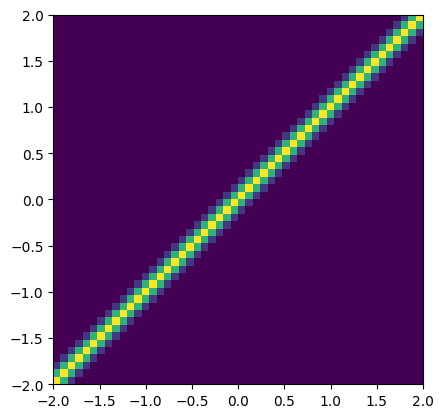

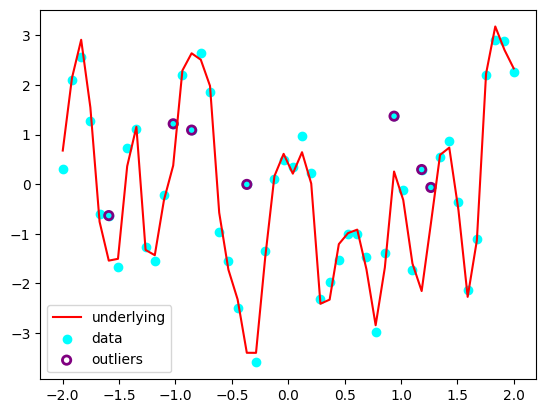

In [2]:
N = 50
num_outliers = int(0.15 * N)
X = jnp.linspace(-2., 2., N)[:, None]
true_sigma, true_l, true_uncert = 1., 0.2, 0.2
data_mu = jnp.zeros((N,))

spectral_params_true = dict(
    logits=jnp.asarray([0., 0.]),
    locs=jnp.asarray([0.5, 1.]),
    scales=jnp.asarray([1., 1.])
)
prior_cov = tfpk.SpectralMixture(**spectral_params_true).matrix(X, X) + 1e-13 * jnp.eye(N)

plt.imshow(prior_cov, origin='lower', extent=(X.min(), X.max(), X.min(), X.max()))
plt.show()

Y = jnp.linalg.cholesky(prior_cov) @ random.normal(random.PRNGKey(42), shape=(N,)) + data_mu
Y_obs = Y + true_uncert * random.normal(random.PRNGKey(1), shape=(N,))
outliers_mask = jnp.where(jnp.isin(jnp.arange(N), np.random.choice(N, num_outliers, replace=False)), jnp.asarray(True),
                          jnp.asarray(False))
Y_obs = jnp.where(outliers_mask,
                  random.laplace(random.PRNGKey(1), shape=(N,)),
                  Y_obs)
plt.plot(X[:, 0], Y, c='red', label='underlying')
plt.scatter(X[:, 0], Y_obs, c='cyan', label='data')
plt.scatter(X[outliers_mask, 0], Y_obs[outliers_mask], label='outliers', facecolors='none', edgecolors='purple', lw=2)
plt.legend()
plt.show()


INFO[2023-07-16 11:21:44,195]: Sanity check...
INFO[2023-07-16 11:21:44,650]: Sanity check passed
2023-07-16 11:21:49.348512: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  reduce-window.18 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-07-16 11:21:49.798143: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 1.449736685s
Constant folding an instruction is taking > 1s:

  reduce-window.18 (d

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 42763
# samples: 1540
# slices: 11760.0
# slices / acceptance: 21.0
# likelihood evals / sample: 27.8
# likelihood evals / slice: 2.9
--------
logZ=-87.97 +- 0.1
H=88.0
ESS=511
--------
locs[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
locs[0]: 0.79 +- 0.48 | 0.15 / 0.78 / 1.41 | 0.41 | 1.06
locs[1]: 0.76 +- 0.46 | 0.18 / 0.71 / 1.4 | 0.55 | 0.05
--------
logits[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
logits[0]: -0.13 +- 0.66 | -1.08 / -0.08 / 0.67 | -0.02 | 0.35
logits[1]: -0.02 +- 0.69 | -0.94 / 0.08 / 0.78 | 0.06 | -0.36
--------
scales[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
scales[0]: 1.04 +- 0.54 | 0.29 / 1.05 / 1.79 | 1.63 | 1.38
scales[1]: 1.08 +- 0.55 | 0.33 / 1.12 / 1.81 | 0.32 | 0.15
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.56 +- 0.28 | 0.15 /

WARNING[2023-07-16 11:22:22,120]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


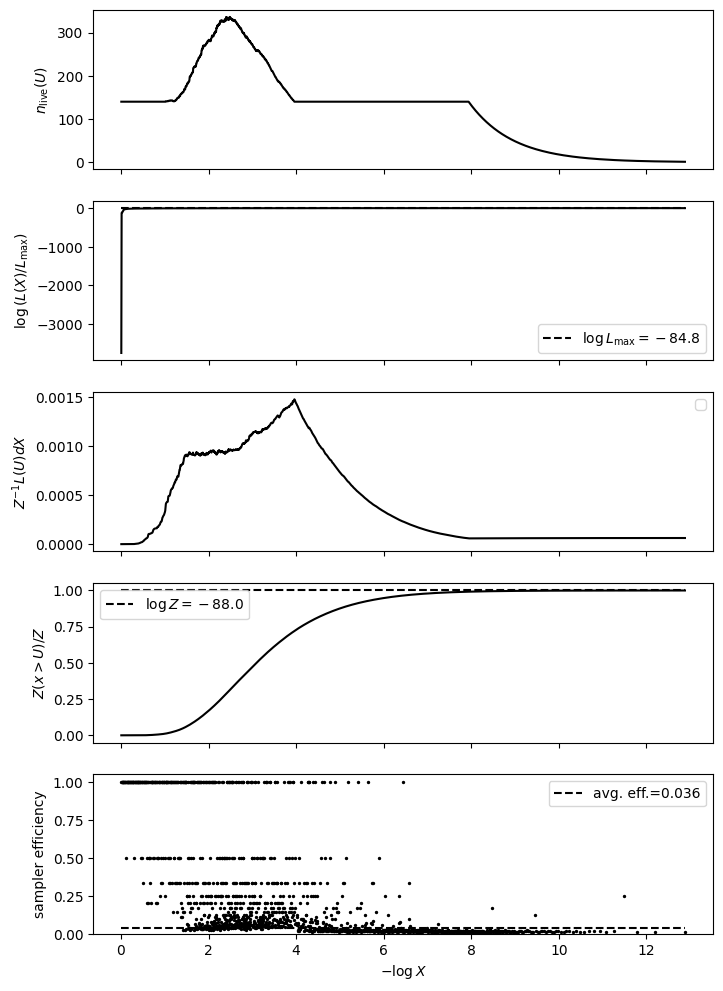

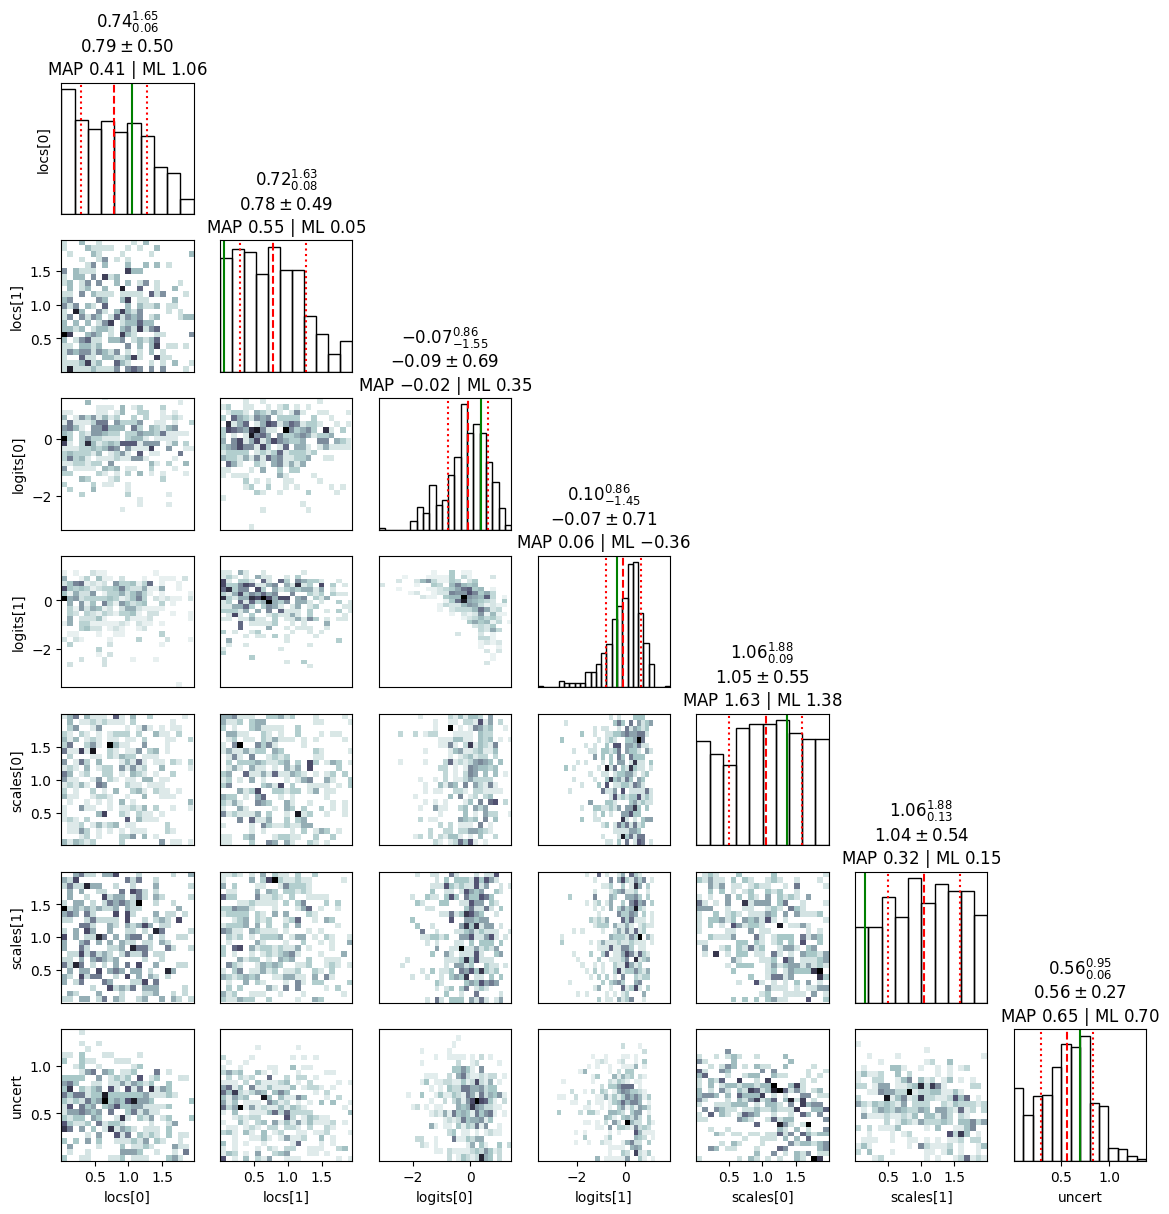

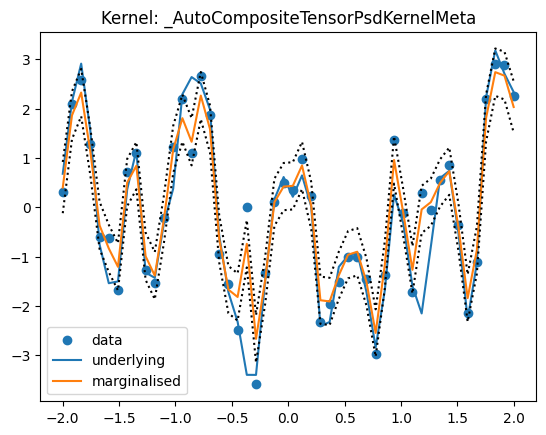

In [3]:


from jaxns import Prior, Model, TerminationCondition, ApproximateNestedSampler

kernel = tfpk.SpectralMixture


def log_normal(x, mean, cov):
    L = jnp.linalg.cholesky(cov)
    # U, S, Vh = jnp.linalg.svd(cov)
    log_det = jnp.sum(jnp.log(jnp.diag(L)))  # jnp.sum(jnp.log(S))#
    dx = x - mean
    dx = solve_triangular(L, dx, lower=True)
    # U S Vh V 1/S Uh
    # pinv = (Vh.T.conj() * jnp.where(S!=0., jnp.reciprocal(S), 0.)) @ U.T.conj()
    maha = dx @ dx  # dx @ pinv @ dx#solve_triangular(L, dx, lower=True)
    log_likelihood = -0.5 * x.size * jnp.log(2. * jnp.pi) - log_det - 0.5 * maha
    return log_likelihood


def log_likelihood(uncert, kernel_params):
    """
    P(Y|sigma, half_width) = N[Y, f, K]
    Args:
        sigma:
        l:

    Returns:

    """
    K = kernel(**kernel_params).matrix(X, X)
    data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
    mu = jnp.zeros_like(Y_obs)
    return log_normal(Y_obs, mu, K + data_cov)


def predict_f(uncert, locs, scales, logits):
    kernel_params = dict(locs=locs,
                         scales=scales,
                         logits=logits)
    K = kernel(**kernel_params).matrix(X, X)
    data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
    mu = jnp.zeros_like(Y_obs)
    return mu + K @ jnp.linalg.solve(K + data_cov, Y_obs)


def predict_fvar(uncert, locs, scales, logits):
    kernel_params = dict(locs=locs,
                         scales=scales,
                         logits=logits)
    K = kernel(**kernel_params).matrix(X, X)
    data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
    mu = jnp.zeros_like(Y_obs)
    return jnp.diag(K - K @ jnp.linalg.solve(K + data_cov, K))


# Build the model
n_components = 2


def prior_model():
    locs = yield ForcedIdentifiability(n=2, low=0., high=2., name='locs')
    scales = yield Prior(tfpd.Uniform(0. * jnp.ones(n_components), 2. * jnp.ones(n_components)), name='scales')
    logits = yield Prior(tfpd.Normal(0. * jnp.ones(n_components), 1. * jnp.ones(n_components)), name='logits')
    kernel_params = dict(locs=locs,
                         scales=scales,
                         logits=logits)
    uncert = yield Prior(tfpd.HalfNormal(1.), name='uncert')
    return uncert, kernel_params


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)

# Create the nested sampler class. In this case without any tuning.
exact_ns = ApproximateNestedSampler(model=model, 
                                    num_live_points=model.U_ndims * 20,
                                    max_samples=1e6,
                                    num_parallel_samplers=1)

termination_reason, state = exact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
results = exact_ns.to_results(state, termination_reason)

exact_ns.summary(results)
exact_ns.plot_diagnostics(results)
exact_ns.plot_cornerplot(results)

predict_f = marginalise_dynamic(random.PRNGKey(42), results.samples, results.log_dp_mean,
                                results.ESS, predict_f)

predict_fvar = marginalise_dynamic(random.PRNGKey(42), results.samples, results.log_dp_mean,
                                   results.ESS, predict_fvar)

plt.scatter(X[:, 0], Y_obs, label='data')
plt.plot(X[:, 0], Y, label='underlying')
plt.plot(X[:, 0], predict_f, label='marginalised')
plt.plot(X[:, 0], predict_f + jnp.sqrt(predict_fvar), ls='dotted',
         c='black')
plt.plot(X[:, 0], predict_f - jnp.sqrt(predict_fvar), ls='dotted',
         c='black')
plt.title("Kernel: {}".format(kernel.__class__.__name__))
plt.legend()
plt.show()
